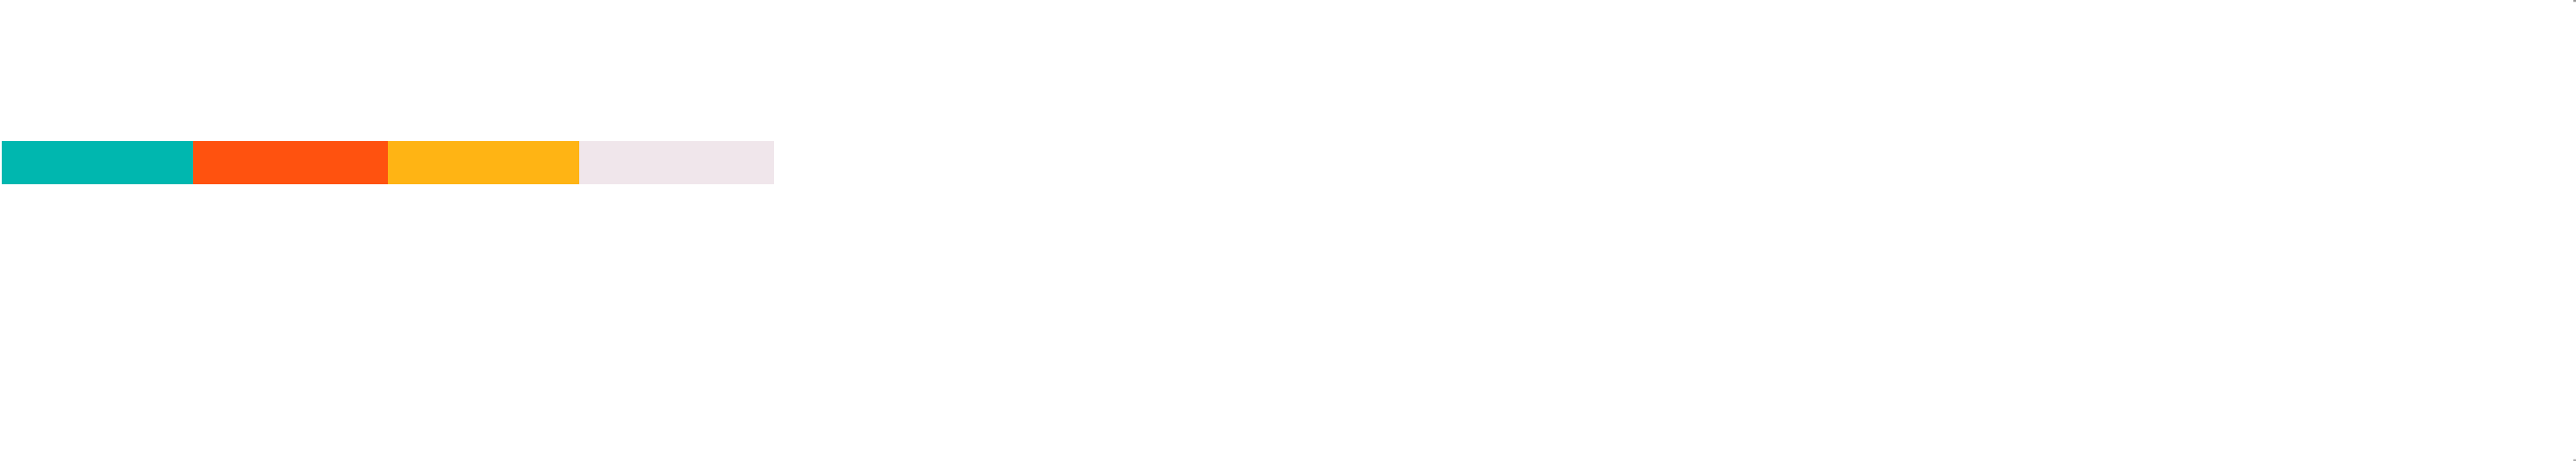

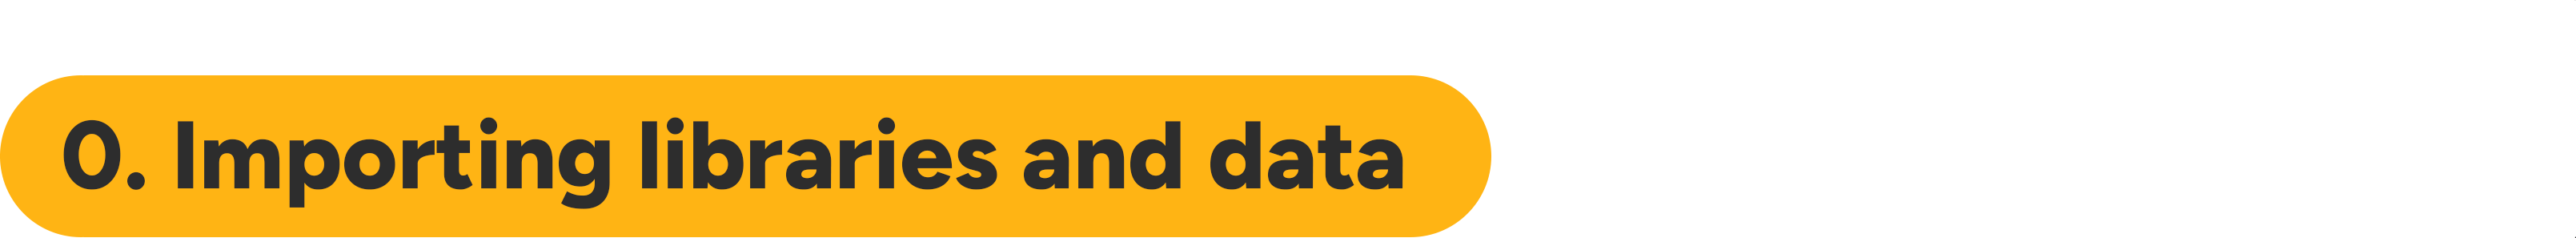

In [105]:
import glob
import os
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import ta
from statsmodels.tsa.stattools import adfuller, kpss
from tsfracdiff import FractionalDifferentiator
from hmmlearn import hmm

sns.set(style='dark', palette='viridis')

In [139]:
directory_path = 'forex_lite'
files = glob.glob(os.path.join(directory_path, '*.csv'))

forex = pd.DataFrame()
content = []
for i in files:
    df = pd.read_csv(i, index_col='Date', header=0)
    content.append(df)

forex = pd.concat(content, axis=1)
forex.dropna(inplace=True)
forex.index = pd.to_datetime(forex.index)

forex

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18 22:05:00,0.98401,99.159,93.246,123.528,1.88498,78.817,5.79210,28.950
2013-03-18 22:10:00,0.98431,99.167,93.245,123.507,1.88536,78.815,5.79153,28.947
2013-03-18 22:15:00,0.98440,99.157,93.231,123.536,1.88551,78.810,5.79213,28.956
2013-03-18 22:20:00,0.98448,99.182,93.206,123.531,1.88563,78.822,5.79259,28.970
2013-03-18 22:25:00,0.98445,99.229,93.179,123.589,1.88564,78.853,5.79234,28.963
...,...,...,...,...,...,...,...,...
2024-05-07 10:05:00,0.59906,101.990,112.977,166.347,1.69644,92.828,10.86585,27.204
2024-05-07 10:10:00,0.59900,101.995,112.965,166.364,1.69645,92.822,10.86554,27.205
2024-05-07 10:15:00,0.59904,102.016,112.973,166.376,1.69645,92.828,10.86469,27.194


In [140]:
returns = forex.pct_change().dropna()
returns

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18 22:10:00,0.000305,0.000081,-0.000011,-0.000170,0.000202,-0.000025,-0.000098,-0.000104
2013-03-18 22:15:00,0.000091,-0.000101,-0.000150,0.000235,0.000080,-0.000063,0.000104,0.000311
2013-03-18 22:20:00,0.000081,0.000252,-0.000268,-0.000040,0.000064,0.000152,0.000079,0.000483
2013-03-18 22:25:00,-0.000030,0.000474,-0.000290,0.000470,0.000005,0.000393,-0.000043,-0.000242
2013-03-18 22:30:00,-0.000345,0.000322,-0.000129,0.000663,-0.000440,0.000482,-0.000076,0.000138
...,...,...,...,...,...,...,...,...
2024-05-07 10:05:00,0.000334,0.000392,0.000035,-0.000084,-0.000136,0.000302,-0.000258,0.000552
2024-05-07 10:10:00,-0.000100,0.000049,-0.000106,0.000102,0.000006,-0.000065,-0.000029,0.000037
2024-05-07 10:15:00,0.000067,0.000206,0.000071,0.000072,0.000000,0.000065,-0.000078,-0.000404


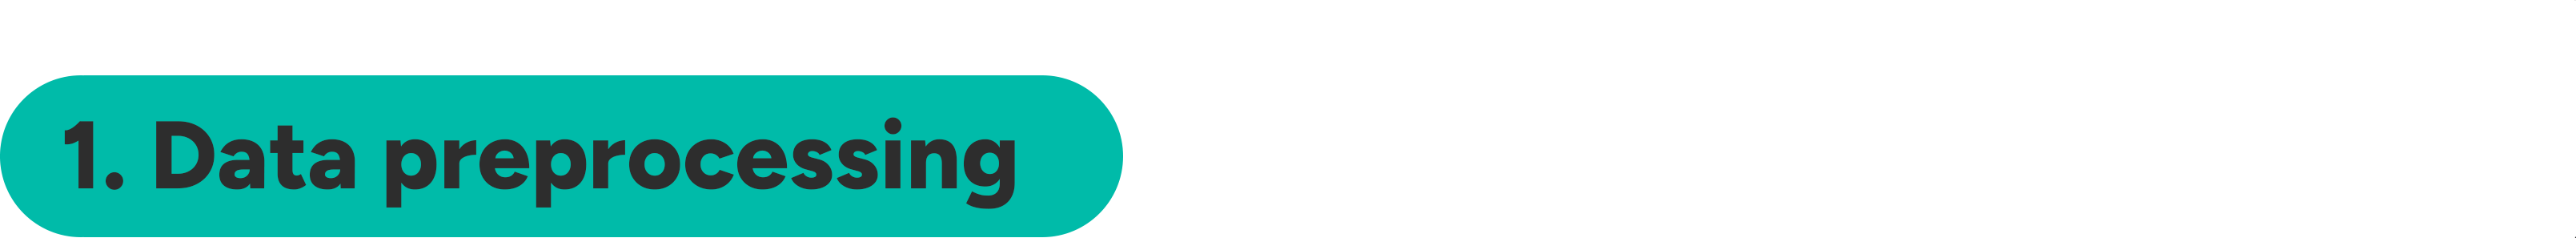

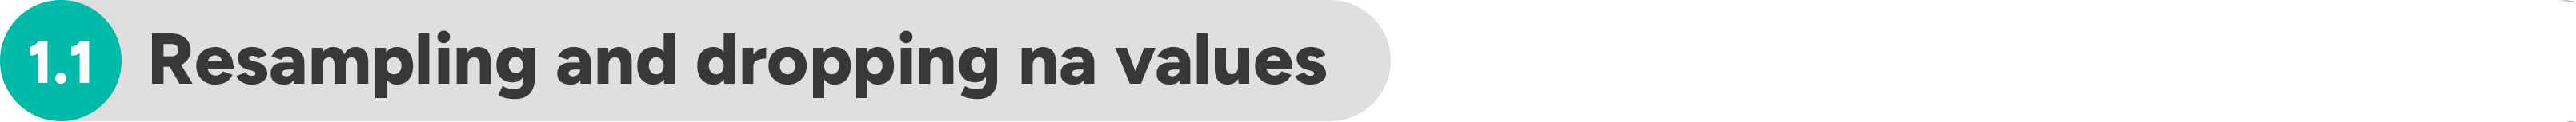

Resampling (5 min interval to daily interval) + dropping nans (for non trading days)

In [141]:
returns_hourly = returns.resample('h').mean()
returns_hourly.dropna(inplace = True)
returns_hourly

,AUDCHF,AUDJPY,CADJPY,EURJPY,GBPSGD,NZDJPY,USDNOK,XAGUSD
Date,,,,,,,,
2013-03-18 22:00:00,0.000001,0.000134,-0.000019,0.000173,1.327854e-05,0.000055,-0.000007,0.000038
2013-03-18 23:00:00,-0.000041,0.000041,0.000160,0.000096,2.236854e-06,0.000015,-0.000149,-0.000023
2013-03-19 00:00:00,-0.000075,0.000031,0.000089,0.000079,3.845350e-05,0.000041,0.000091,-0.000155
2013-03-19 01:00:00,0.000032,-0.000128,0.000096,-0.000152,8.412611e-06,-0.000034,0.000013,0.000161
2013-03-19 02:00:00,-0.000006,0.000032,-0.000124,0.000032,-8.741237e-07,0.000005,0.000001,0.000012
...,...,...,...,...,...,...,...,...
2024-05-07 06:00:00,-0.000166,-0.000214,-0.000120,-0.000059,1.621365e-05,-0.000171,-0.000047,-0.000122
2024-05-07 07:00:00,0.000054,-0.000019,-0.000121,-0.000118,-6.924924e-05,-0.000091,0.000050,-0.000079
2024-05-07 08:00:00,0.000118,0.000141,0.000184,0.000147,5.257899e-05,0.000180,-0.000045,0.000114


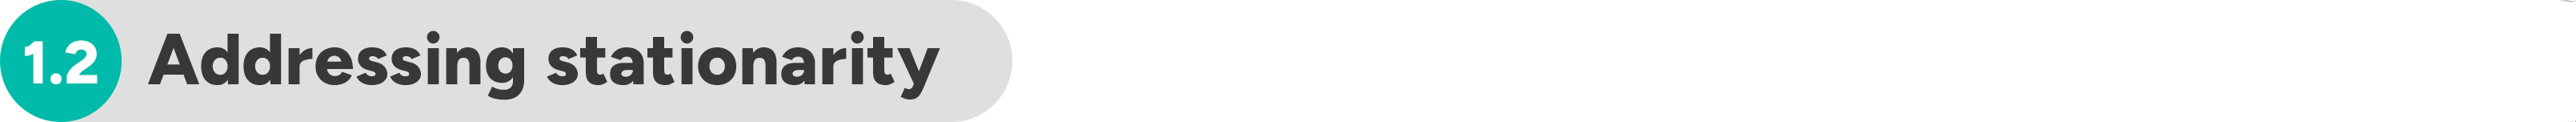

Stationarity is a necessary, non-sufficient condition for the high performance of an ML algorithm.

**PROBLEM**: there is a trade-off between stationarity and memory.
* too much differencing = stationary BUT no memory

**SOLUTION**: use fractional differencing, i.e. minimum degree of differencing, just enuf to pass adf test

Visual inspection

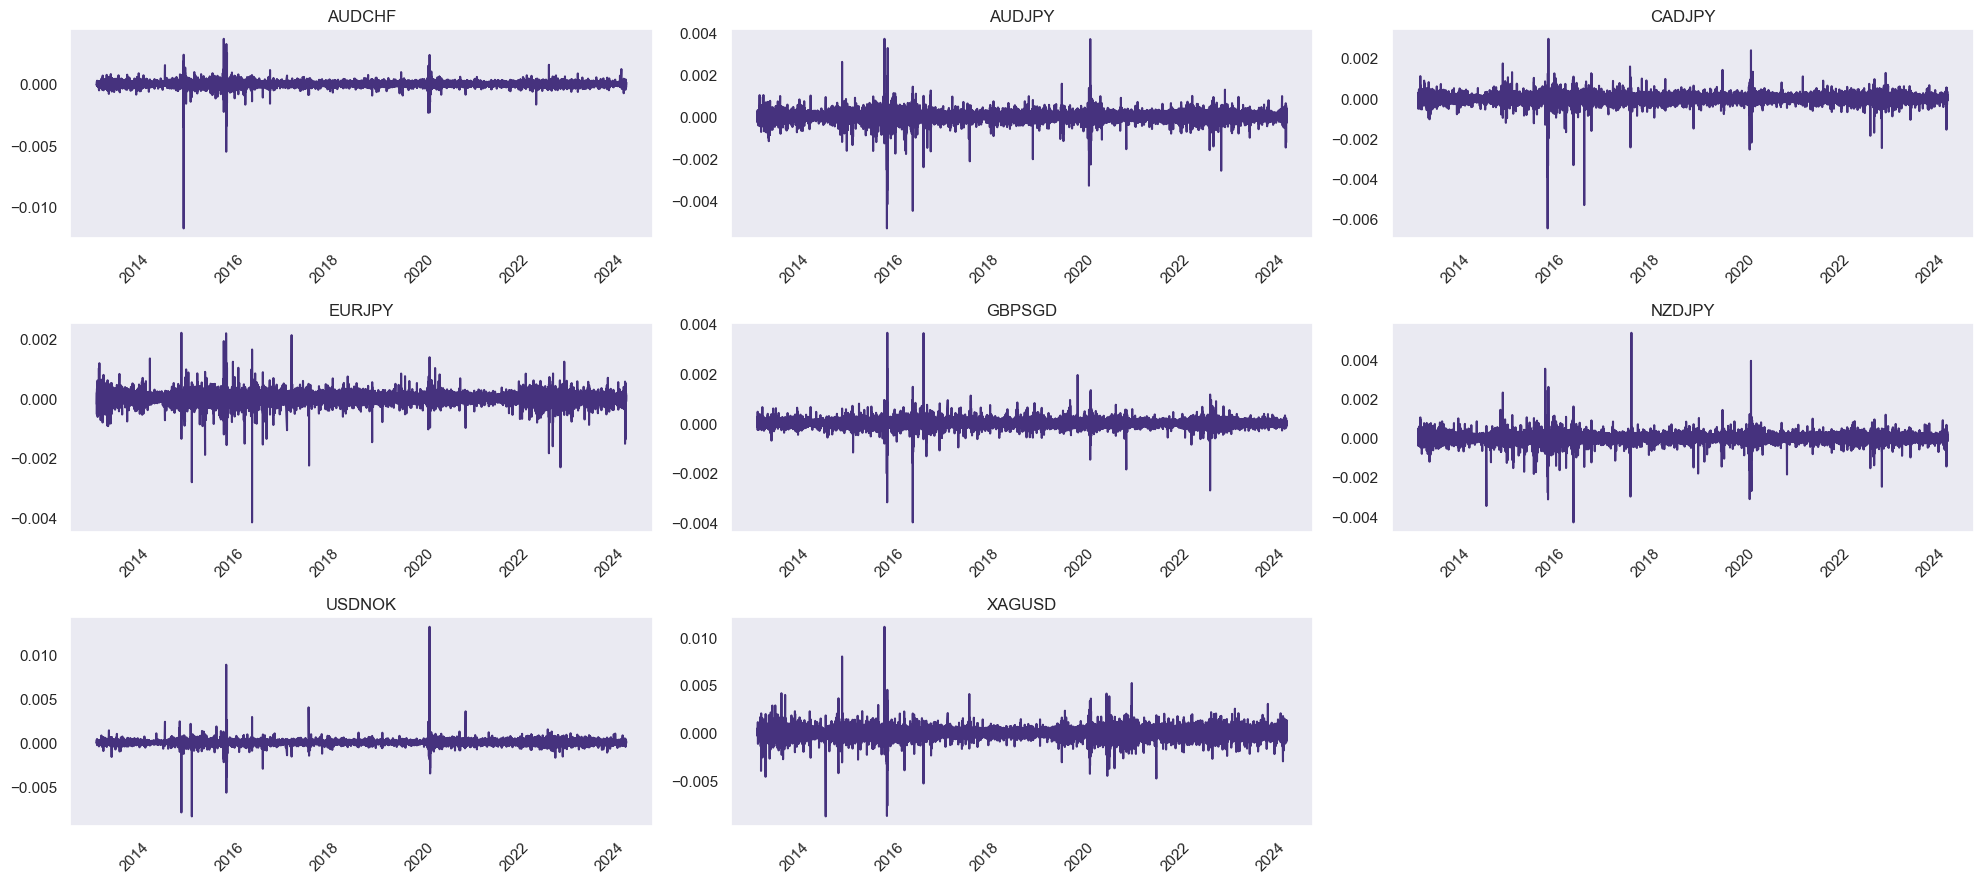

In [142]:
num_plots = len(returns_hourly.columns)
nrows = (num_plots // 3) + (1 if num_plots % 3 else 0)
ncols = min(3, num_plots)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, 9))

axes = axes.flatten()

for i, column in enumerate(returns_hourly.columns):
    axes[i].plot(returns_hourly.index, returns_hourly[column])
    axes[i].set_title(column)
    axes[i].tick_params(axis = "x", rotation = 45)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

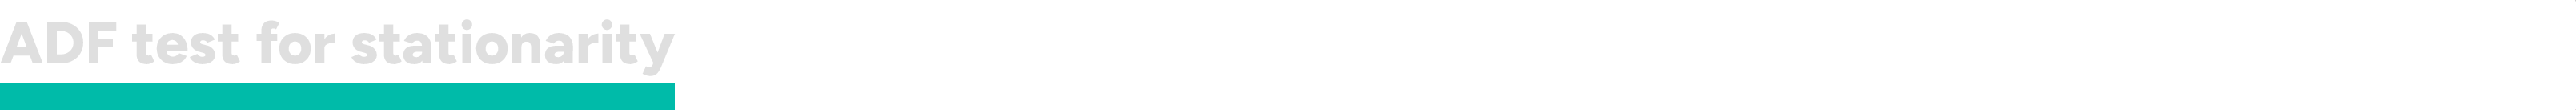

In [143]:
adf_results = []
for pair in returns_hourly.columns:
    result = adfuller(returns_hourly[pair])
    adf_stat = result[0]
    p = result[1]
    adf_results.append((pair, adf_stat, p))

adf_results = pd.DataFrame(adf_results, columns = ['pair', 'adf_stat', 'p'])
display(adf_results)
print(f'\nNumber of pairs with a p-value > 0.05 (non stationary): {sum(adf_results.p > 0.05)} out of {len(adf_results)} pairs.')
adf_non_stationary = adf_results[adf_results["p"] > 0.05].reset_index(drop = True)
adf_non_stationary

# big p = bad

,pair,adf_stat,p
0,AUDCHF,-32.780209,0.0
1,AUDJPY,-30.692755,0.0
2,CADJPY,-28.862284,0.0
3,EURJPY,-51.176537,0.0
4,GBPSGD,-38.297709,0.0
5,NZDJPY,-32.638099,0.0
6,USDNOK,-35.182034,0.0
7,XAGUSD,-35.351346,0.0



Number of pairs with a p-value > 0.05 (non stationary): 0 out of 8 pairs.


,pair,adf_stat,p


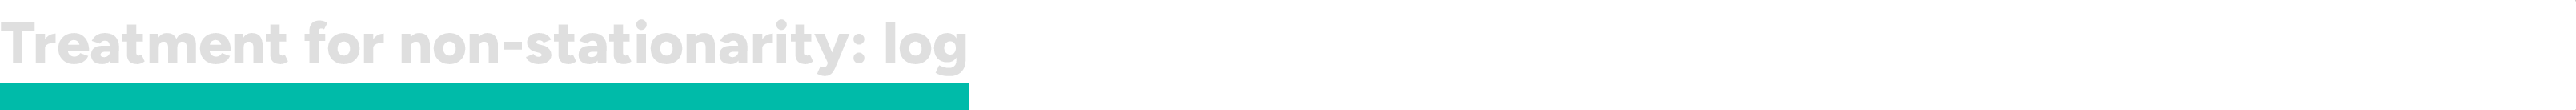

Source: textbook page 160, 161

In [144]:
non_stationary_pairs = []

print('Currency:     p-value')
for column in returns_hourly.columns:
    result = adfuller(returns_hourly[column])
    p_value = result[1]
    print(f'{column}:   {p_value}')
    if p_value > 0.05:
        non_stationary_pairs.append(column)

print("\nNon-stationary pairs (p > 0.05):")
non_stationary_pairs

Currency:     p-value
AUDCHF:   0.0
AUDJPY:   0.0
CADJPY:   0.0
EURJPY:   0.0
GBPSGD:   0.0
NZDJPY:   0.0
USDNOK:   0.0
XAGUSD:   0.0

Non-stationary pairs (p > 0.05):


[]

all = stationary -> NO NEEF for log to stabilise a bit

Checking to see if logging has stabilise the data enuf:

not enuf -> frac diff (note: were using ADF fuller test result as a benchmark)

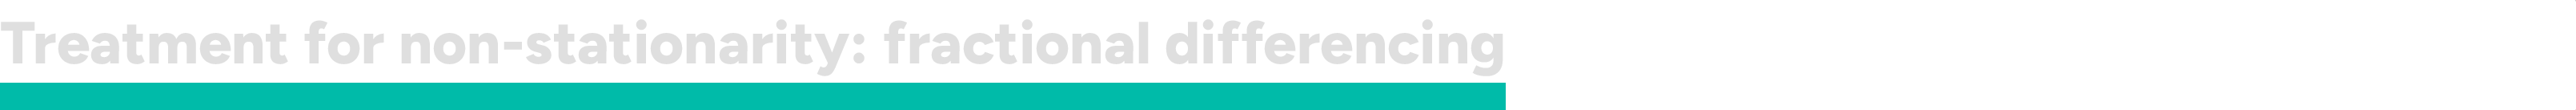

recommendation: plots of statistics to show structural breaks or lack therefof to determine appropriate stationarity test and change fracdiff stationarity benchmark

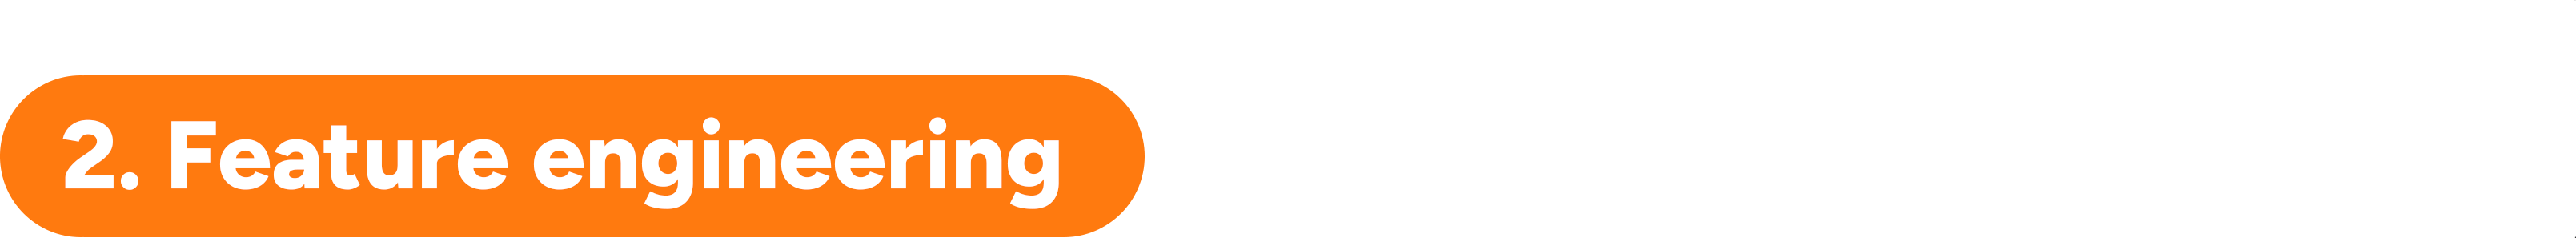

https://alphascientist.com/feature_engineering.html

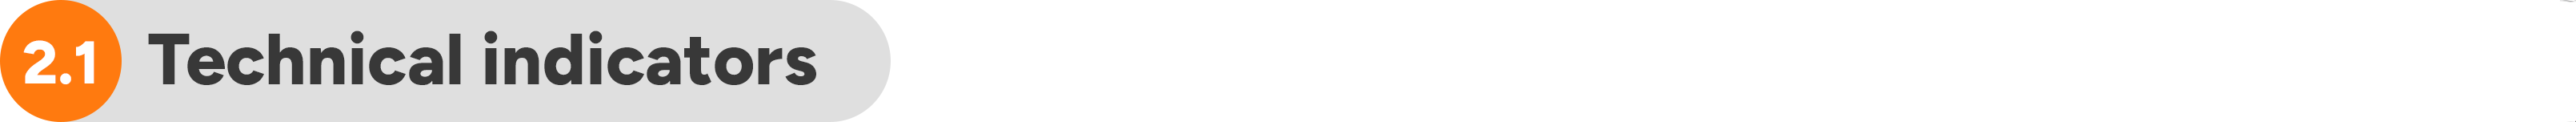

consider: spreads, changes in bid prices, changes in ask prices, differences in bid and ask volumes, volatility of bid prices, and volatility of ask prices. 

Lets just pick out AUDCHF as an example to see how the `features` df is formed for each price path.

In [164]:
# Pick out a single path to demonstrate how the features df is created
AUDCHF = returns_hourly['AUDCHF']
features_AUDCHF = pd.DataFrame()

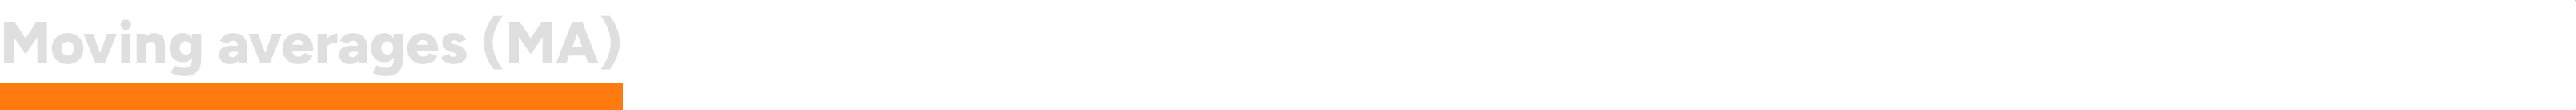

Simple moving average (sma), exponential moving average (EMA)

In [170]:
features_AUDCHF['sma_10'] = ta.trend.sma_indicator(returns_hourly['AUDCHF'], window=10)
features_AUDCHF['sma_20'] = ta.trend.sma_indicator(returns_hourly['AUDCHF'], window=20)

features_AUDCHF['ema_10'] = ta.trend.ema_indicator(returns_hourly['AUDCHF'], window=10)
features_AUDCHF['ema_20'] = ta.trend.ema_indicator(returns_hourly['AUDCHF'], window=20)

Volatility - Exponential weighted moving average (EWMA)

In [166]:
def volatility_with_log_returns(
        close: pd.Series,
        span: int = 100 # determines how much weight is assigned to the previous observations in the EWMA calculation
) -> pd.Series:
    """
    Calculate the daily volatility at intraday estimation points using Exponentially Weighted Moving Average (EWMA).

    :param close: A pandas Series of daily close prices.
    :param span: The span parameter for the Exponentially Weighted Moving Average (EWMA).
    :return: A pandas Series containing daily volatilities.

    References:
    - De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons. (Methodology: Page 44)
    """
    
    df = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    # searchsorted method returns the index of the first element in the array that is greater than the search value
        
    df = df[df > 0] # filters out the non-positive values from the df array, ensuring that only valid indices are considered
    df = pd.Series(close.index[df - 1], index=close.index[close.shape[0] - df.shape[0]:])
    returns = np.log(close.loc[df.index] / close.loc[df.values].values)
    stds = returns.ewm(span=span).std().rename("std")
    # essentially its just using an alpha param that is determined by the span, then use that as kinda like a weight
    # param for the std method nothin 2 complicated

    return stds

In [169]:
features_AUDCHF['volatility'] = volatility_with_log_returns(returns_hourly['AUDCHF'], 100)

c:\Users\kalul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Consider: integrated window moving average (IWMA)

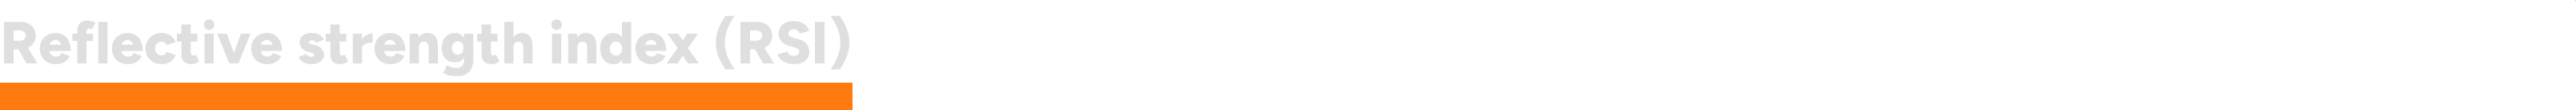

In [171]:
features_AUDCHF['rsi'] = ta.momentum.rsi(returns_hourly['AUDCHF'])
features_AUDCHF['macd'] = ta.trend.macd_diff(returns_hourly['AUDCHF'])
features_AUDCHF['bb_upper'], features_AUDCHF['bb_middle'], features_AUDCHF['bb_lower'] = \
    ta.volatility.bollinger_hband_indicator(returns_hourly['AUDCHF']), ta.volatility.bollinger_mavg(returns_hourly['AUDCHF']), \
    ta.volatility.bollinger_lband_indicator(returns_hourly['AUDCHF'])

Normalisation of features

In [154]:
features_AUDCHF.tail()

,sma_10,sma_20,ema_10,ema_20,volatility
Date,,,,,
2024-05-07 06:00:00,-0.000032,-1.630702e-05,-0.000060,-0.000029,0.002502
2024-05-07 07:00:00,-0.000029,-1.206149e-05,-0.000039,-0.000021,0.002551
2024-05-07 08:00:00,-0.000016,-6.977360e-06,-0.000010,-0.000008,0.002560
2024-05-07 09:00:00,-0.000022,-3.852366e-06,-0.000012,-0.000009,0.002553
2024-05-07 10:00:00,-0.000021,6.700064e-07,0.000016,0.000005,0.002551


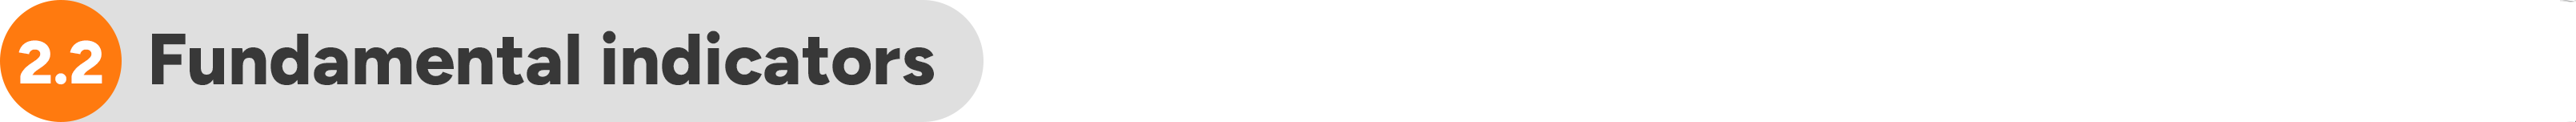

https://arxiv.org/pdf/2002.10247

Consumer Price Index (CPI) 
● Index of Industrial Production (IIP) 
● Interest Rates 
● Money Supply 
● Total Reserves 
● Stock Market Index 
● Trade (Net Exports)

news / market sentiment

https://www.epchan.com/What%20we%20learned%20from%20Kaggle%20Two-Sigma%20News%20Sentiment%20competition.pdf

Sentiment and Economic Indicators:

Interest Rates: Changes in interest rates can affect currency values.
Economic Data Releases: Reports such as GDP, employment numbers, and inflation rates can impact currency markets.
Market Sentiment Indicators: Sentiment analysis from news, social media, or trader positioning data.
Cross-Currency Relationships:

Correlations: Strength and direction of relationships between different currency pairs.
Currency Strength: Relative strength of a currency compared to others in a pair.

interest rates = fewer rows than forex price -> X work

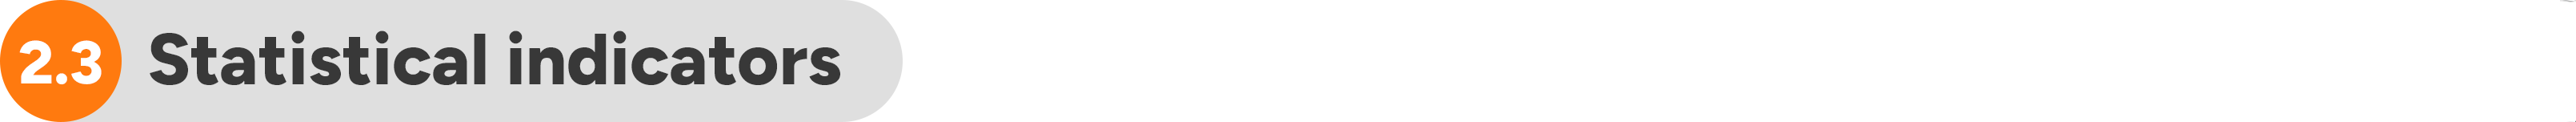

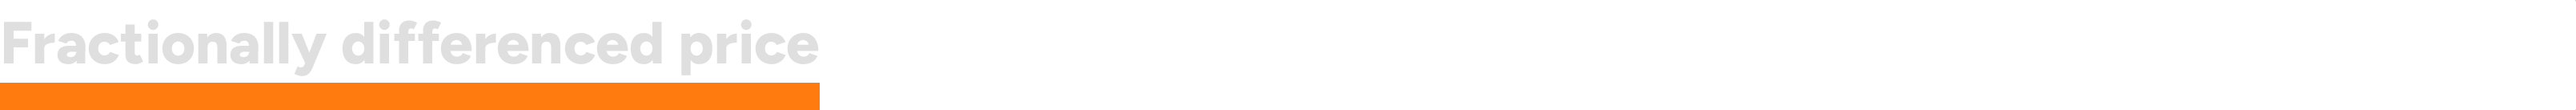

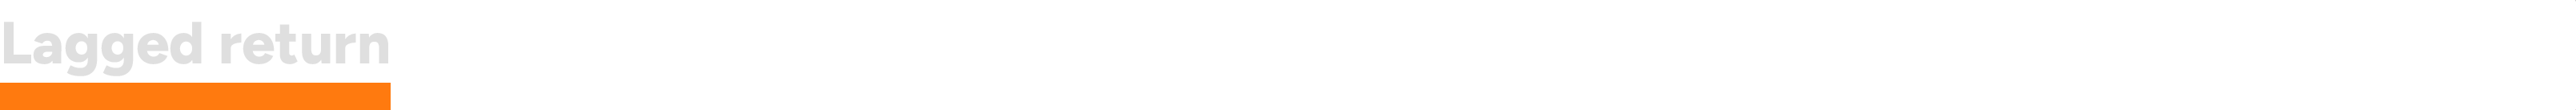

The approach of using lagged returns, and more generally past realizations of the price signal, as input for a RNN follows the recent work of Fischer and Krauss (2018), who find it to deliver highly accurate forecasts. We acknowledge that different ways to set up the forecasting tasks are possible and could consist of using technical indicators as additional signal and/or incorporating price signals from other financial instruments (e.g., other exchange rates than the one being forecast), among others

We use the time series of scaled returns as the sole feature, with the input at time t consisting of the sequence of returns of the previous trading days: https://link.springer.com/article/10.1007/s42521-020-00019-x

In [172]:
# trend from the past 1, 2, 3, 4, 5 hours
def create_lagged_features(data, pair, lag):
    df = data[[pair]].copy()
    for i in range(1, lag + 1):
        df[f'price_lag_{i}'] = df[pair].shift(i)
    return df

lagged_features = create_lagged_features(returns_hourly, 'AUDCHF', lag=5) 
lagged_features

,AUDCHF,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5
Date,,,,,,
2013-03-18 22:00:00,0.000001,NaN,NaN,NaN,NaN,NaN
2013-03-18 23:00:00,-0.000041,0.000001,NaN,NaN,NaN,NaN
2013-03-19 00:00:00,-0.000075,-0.000041,0.000001,NaN,NaN,NaN
2013-03-19 01:00:00,0.000032,-0.000075,-0.000041,0.000001,NaN,NaN
2013-03-19 02:00:00,-0.000006,0.000032,-0.000075,-0.000041,0.000001,NaN
...,...,...,...,...,...,...
2024-05-07 06:00:00,-0.000166,-0.000046,-0.000268,0.000064,-0.000036,-0.000057
2024-05-07 07:00:00,0.000054,-0.000166,-0.000046,-0.000268,0.000064,-0.000036
2024-05-07 08:00:00,0.000118,0.000054,-0.000166,-0.000046,-0.000268,0.000064


In [173]:
features_AUDCHF = features_AUDCHF.merge(lagged_features.iloc[:, 1:], how = 'inner', left_index = True, right_index = True)
features_AUDCHF.tail(3)

,sma_10,sma_20,ema_10,ema_20,rsi,macd,bb_upper,bb_middle,bb_lower,volatility,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5
Date,,,,,,,,,,,,,,,
2024-05-07 08:00:00,-0.000016,-6.977360e-06,-0.000010,-0.000008,54.203484,0.000006,0.0,-6.977360e-06,0.0,1.579008,0.000054,-0.000166,-0.000046,-0.000268,0.000064
2024-05-07 09:00:00,-0.000022,-3.852366e-06,-0.000012,-0.000009,49.642748,0.000005,0.0,-3.852366e-06,0.0,1.579008,0.000118,0.000054,-0.000166,-0.000046,-0.000268
2024-05-07 10:00:00,-0.000021,6.700064e-07,0.000016,0.000005,54.409145,0.000014,0.0,6.700064e-07,0.0,1.551379,-0.000017,0.000118,0.000054,-0.000166,-0.000046


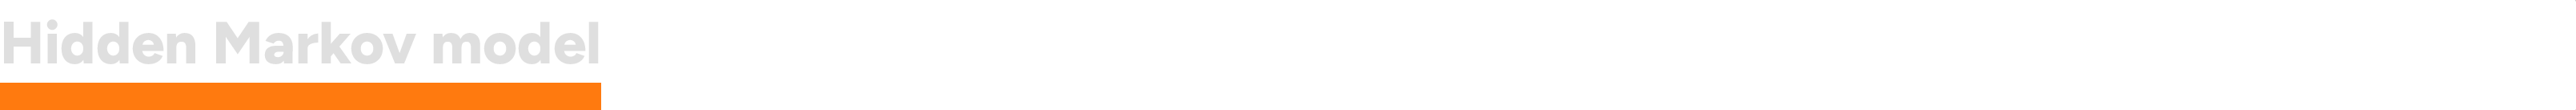

Why

When
 dealing with regime shifts, we expect Markov
 switching models to perform better than simple
 data partitions based on thresholds. For example,
 in Figure 1, if we had simply classified the observa
 tions that were in the highest quartile as being
 associated with Regime 2 (the high-mean regime),
 we would have misidentified the actual regime 40
 times out of 200 observations. In contrast, a well
 calibrated Markov-switching model would have
 misidentified the actual regime only three times.
 Arbitrary thresholds give false signals because they
 fail to capture the persistence in regimes as well as
 changing volatilities. For example, because Regime
 2 has higher volatility, a large negative value is
 most likely to come from this regime, even though
 it has a higher mean. Likewise, if the previous
 observation were volatile, the current observation
 would be more likely associated with Regime 2,
 even though a simple threshold might classify it as
 part of the quiet regime. Markov-switching models
 are designed to capture these features of the data.

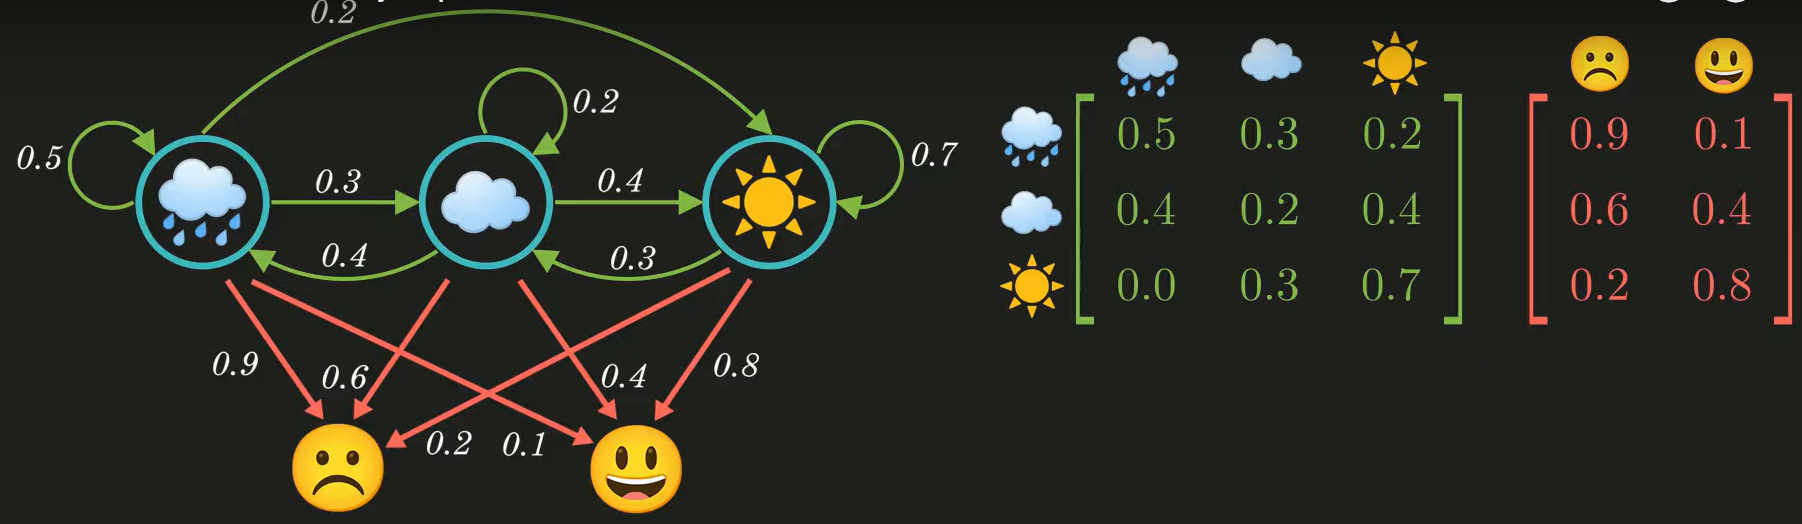

Transtition matrix = the first one - between states

Emission matrix = the second one - pr of observations being generated based on hidden states.

EACH STATE = ONLY DEPENDENT ON THE STATE THE DAY PRIOR

EACH OBSERVATIONS = ONLY DEPENDENT ON TODAY'S STATE

**HMM Tasks**
* Evaluation: Given a model and a sequence of observations, compute the probability of the observations.
* Decoding: Given a model and a sequence of observations, find the most likely sequence of hidden states.
* Learning: Given a sequence of observations, adjust the model parameters to best fit the data.

Since we dont have the model -> we wanna learn from the data -> EM algorithm / Baum-Welch

**Steps to Train an HMM**
* Initialisation: Start with random guesses for the model parameters (transition and emission probabilities).
* Expectation Step: Compute the expected values of the hidden states using the current parameters (Forward-Backward algorithm).
* Maximisation Step: Re-estimate the model parameters to maximise the likelihood of the observed data.
* Iteration: Repeat the Expectation and Maximisation steps until convergence.

To do
1. Define regimes
2. Create transitn matrix and calibrate initial and trans probability
3. Simulate

2 state assumption

we assumed that observations from Regime 1 were normally distributed with a given mean and stan dard deviation and that observations from Regime 2 were normally distributed with a different mean and standard deviation. Sev

**Types of Regime Switching Models**
1. Markov Switching Autoregressive Model (MS-AR)

2. Markov Switching Vector Autoregressive Model (MS-VAR)

3. Markov Switching GARCH Model (MS-GARCH)

**Estimation**
1. Maximum Likelihood Estimation (MLE)

* most common
2. Expectation-Maximisation (EM)
* E: algorithm calculates the expected value of the complete data log-likelihood, given the observed data and current parameter estimates (State Probabilities & Expected Log-Likelihood)
* M: maximises the expected log-likelihood obtained from the E-step; Update / re-estimate the parameters (e.g., transition probabilities, state-specific means, and variances) to maximise the expected log-likelihood. Iterate until the changes in parameter estimates are sufficiently small, indicating convergence.

3. Baum-Welch algorithm
* specific instance of the EM algorithm (#2) used for Hidden Markov Models (HMMs)

**THIS ONE = BAUM WELCH; two state model governed by simple discrete distribution**


https://github.com/tianyu-z/Kritzman-Regime-Detection/tree/master

https://scikit-learn.sourceforge.net/stable/modules/hmm.html

https://medium.com/analytics-vidhya/baum-welch-algorithm-for-training-a-hidden-markov-model-part-2-of-the-hmm-series-d0e393b4fb86`

https://github.com/lopatovsky/HMMs/blob/master/hmms.ipynb

https://github.com/hmmlearn/hmmlearn/blob/main/examples/plot_gaussian_model_selection.py

In [182]:
features_AUDCHF.dropna()

,sma_10,sma_20,ema_10,ema_20,rsi,macd,bb_upper,bb_middle,bb_lower,volatility,price_lag_1,price_lag_2,price_lag_3,price_lag_4,price_lag_5
Date,,,,,,,,,,,,,,,
2013-03-20 08:00:00,0.000005,2.056244e-05,-0.000003,0.000003,49.690890,-0.000006,0.0,2.056244e-05,0.0,2.029704,-0.000093,0.000081,-0.000037,-0.000005,-0.000036
2013-03-20 09:00:00,-0.000006,1.482520e-05,-0.000016,-0.000005,45.839282,-0.000010,0.0,1.482520e-05,0.0,1.867543,-0.000003,-0.000093,0.000081,-0.000037,-0.000005
2013-03-20 10:00:00,-0.000019,5.051929e-06,-0.000032,-0.000014,44.498350,-0.000013,0.0,5.051929e-06,0.0,2.195147,-0.000078,-0.000003,-0.000093,0.000081,-0.000037
2013-03-20 11:00:00,-0.000023,-5.524946e-06,-0.000029,-0.000014,49.817660,-0.000009,0.0,-5.524946e-06,0.0,2.282437,-0.000105,-0.000078,-0.000003,-0.000093,0.000081
2013-03-20 12:00:00,-0.000031,-4.890172e-06,-0.000027,-0.000015,49.533940,-0.000006,0.0,-4.890172e-06,0.0,2.164873,-0.000014,-0.000105,-0.000078,-0.000003,-0.000093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07 06:00:00,-0.000032,-1.630702e-05,-0.000060,-0.000029,44.859763,-0.000019,0.0,-1.630702e-05,0.0,1.609047,-0.000046,-0.000268,0.000064,-0.000036,-0.000057
2024-05-07 07:00:00,-0.000029,-1.206149e-05,-0.000039,-0.000021,52.274410,-0.000006,0.0,-1.206149e-05,0.0,1.579008,-0.000166,-0.000046,-0.000268,0.000064,-0.000036
2024-05-07 08:00:00,-0.000016,-6.977360e-06,-0.000010,-0.000008,54.203484,0.000006,0.0,-6.977360e-06,0.0,1.579008,0.000054,-0.000166,-0.000046,-0.000268,0.000064


In [125]:
def hmm_model(data, num_states = 2, n_iter = 100):

    model = hmm.GaussianHMM(n_components=num_states, n_iter=100)
    data = data.to_frame()
    model.fit(data)

    state_probabilities = model.predict_proba(data.values.reshape(-1, 1))

    hidden_states = model.predict(data.values.reshape(-1, 1))

    df = pd.DataFrame({
        'date': data.index,              
        'close': data.values.flatten(),  
        'hidden_state': hidden_states,
        'prob_state_0': state_probabilities[:, 0],
        'prob_state_1': state_probabilities[:, 1],
    })

    return df

def hmm_model_train_test(train_data, test_data, num_states=2, n_iter=100):
    """
    Fit on training data and predict probabilities for test data
    """
    train_data = pd.DataFrame(train_data)
    test_data = pd.DataFrame(test_data)
    
    model = hmm.GaussianHMM(n_components=num_states, n_iter=n_iter)
    model.fit(train_data)
        
    test_state_probabilities = model.predict_proba(test_data)
    hidden_states = model.predict(test_data)

    df = pd.DataFrame({
        'date': test_data.index,              
        'close': test_data.values.flatten(),  
        'hidden_state': hidden_states,
        'prob_state_0': test_state_probabilities[:, 0],
        'prob_state_1': test_state_probabilities[:, 1],
    }).set_index('date').sort_index()

    return df

open view.net

in methodology must argue WHY you split train test

In [161]:
returns_hourly.dropna(inplace = True)
test_no_split = hmm_model(returns_hourly['AUDCHF'], num_states = 2, n_iter = 100)
display(test_no_split)
test_no_split['hidden_state'].value_counts()

Model is not converging.  Current: 446226.56170567736 is not greater than 446254.89527405513. Delta is -28.333568377769552


,date,close,hidden_state,prob_state_0,prob_state_1
0,2013-03-18 22:00:00,0.000001,1,7.484372e-08,1.000000
1,2013-03-18 23:00:00,-0.000041,1,1.731492e-06,0.999998
2,2013-03-19 00:00:00,-0.000075,1,1.775101e-06,0.999998
3,2013-03-19 01:00:00,0.000032,1,1.751076e-06,0.999998
4,2013-03-19 02:00:00,-0.000006,1,1.745519e-06,0.999998
...,...,...,...,...,...
65227,2024-05-07 06:00:00,-0.000166,1,1.895173e-06,0.999998
65228,2024-05-07 07:00:00,0.000054,1,1.763842e-06,0.999998
65229,2024-05-07 08:00:00,0.000118,1,1.820855e-06,0.999998
65230,2024-05-07 09:00:00,-0.000017,1,1.786576e-06,0.999998


hidden_state
1    65204
0       28
Name: count, dtype: int64

<Axes: >

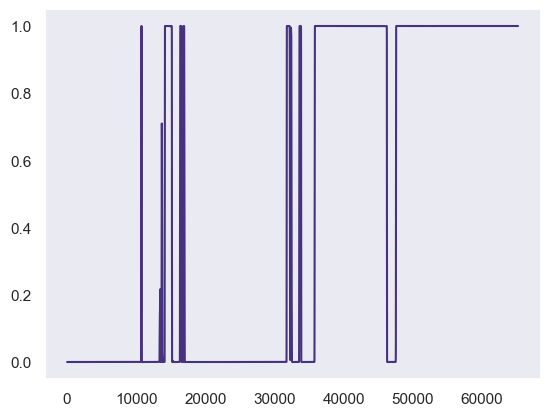

In [127]:
test_no_split['prob_state_0'].plot()

train test set split

Length of train set: 32616
Length of test set: 32616


,close,hidden_state,prob_state_0,prob_state_1
date,,,,
2013-03-18 23:00:00,0.368176,1,0.003068,0.996932
2013-03-19 00:00:00,0.367542,1,0.002749,0.997251
2013-03-19 01:00:00,0.367530,1,0.002849,0.997151
2013-03-19 03:00:00,0.367684,1,0.003060,0.996940
2013-03-19 06:00:00,0.367147,1,0.002773,0.997227
...,...,...,...,...
2024-05-07 03:00:00,0.060539,0,0.692546,0.307454
2024-05-07 04:00:00,0.059648,0,0.715637,0.284363
2024-05-07 06:00:00,0.057483,0,0.682062,0.317938


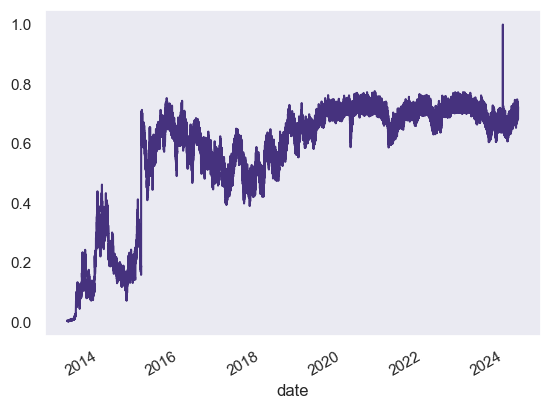

In [128]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(forex_hourly_log['AUDCHF'], test_size = 0.5, random_state = 404)
print(f'Length of train set: {len(train_set)}')
print(f'Length of test set: {len(test_set)}')
train_set[:10]

test_yes_split = hmm_model_train_test(train_set, test_set, num_states=2, n_iter=100)
test_yes_split['prob_state_0'].plot()
test_yes_split

In [129]:
train_set2, test_set2 = train_test_split(forex_hourly_log_frdiff['AUDCHF'], test_size = 0.5, random_state = 404)
print(f'Length of train set2: {len(train_set2)}')
print(f'Length of test set2: {len(test_set2)}')
train_set2[:10]

split = hmm_model_train_test(train_set2, test_set2, num_states=2, n_iter=100)
split['prob_state_0'].plot()
split

Length of train set2: 32616
Length of test set2: 32616


ValueError: Input contains NaN.

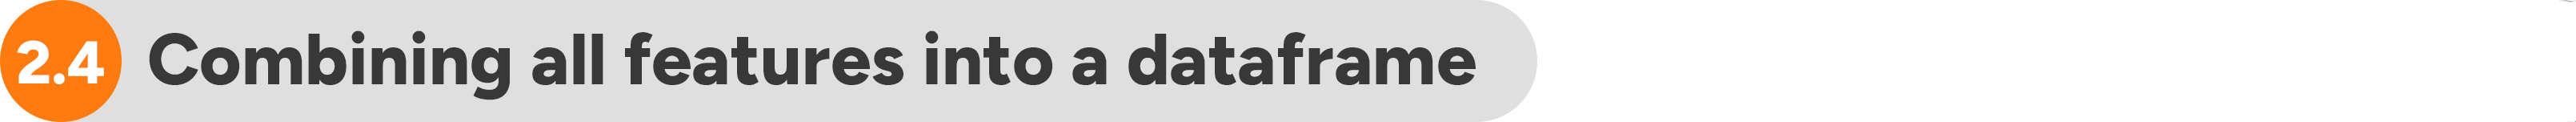

<div class="alert alert-success">
<b>KEY DATAFRAME: forex_daily_log_frdiff</b>
</div>

In [ ]:
for pair in forex_hourly_log_frdiff.columns:
    features = pd.DataFrame()
    price = forex_hourly_log[pair]

    # technical indicators
    features['sma_10'] = ta.trend.sma_indicator(price, window=10)
    features['sma_20'] = ta.trend.sma_indicator(price, window=20)
    features['ema_10'] = ta.trend.ema_indicator(price, window=10)
    features['ema_20'] = ta.trend.ema_indicator(price, window=20)
    features['volatility'] = volatility_with_log_returns(price, 100)

    # statistical indicators
    features['frac_diff'] = forex_hourly_log_frdiff[pair]
    hmm_result_df = hmm_model(price, num_states = 2, n_iter = 100)
    features['prob_state_0'] = hmm_result_df.loc[:, 'prob_state_0'].values
    features['prob_state_1'] = hmm_result_df.loc[:, 'prob_state_1'].values

    features['rsi'] = ta.momentum.rsi(price)
    features['macd'] = ta.trend.macd_diff(price)
    features['bb_upper'] = ta.volatility.bollinger_hband(price)
    features['bb_middle'] = ta.volatility.bollinger_mavg(price)
    features['bb_lower'] = ta.volatility.bollinger_lband(price)

    # fundamental indicators

c:\Users\kalul\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
features

,sma_10,sma_20,ema_10,ema_20,volatility,frac_diff,prob_state_0,prob_state_1,rsi,macd,bb_upper,bb_middle,bb_lower
Date,,,,,,,,,,,,,
2013-03-18 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7.297511e-70,1.0,NaN,NaN,NaN,NaN,NaN
2013-03-18 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.521135e-18,1.0,NaN,NaN,NaN,NaN,NaN
2013-03-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.679273e-18,1.0,NaN,NaN,NaN,NaN,NaN
2013-03-19 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.608883e-18,1.0,NaN,NaN,NaN,NaN,NaN
2013-03-19 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,1.480680e-18,1.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-07 06:00:00,3.326101,3.324585,3.324638,3.322427,0.004859,0.396063,1.300122e-16,1.0,53.354967,-0.001466,3.331835,3.324585,3.317335
2024-05-07 07:00:00,3.325340,3.324709,3.323984,3.322295,0.004810,0.396391,1.348449e-16,1.0,52.109586,-0.001628,3.331619,3.324709,3.317799
2024-05-07 08:00:00,3.324521,3.324887,3.323382,3.322140,0.004766,0.396453,1.384746e-16,1.0,51.172969,-0.001714,3.331158,3.324887,3.318617


drop na

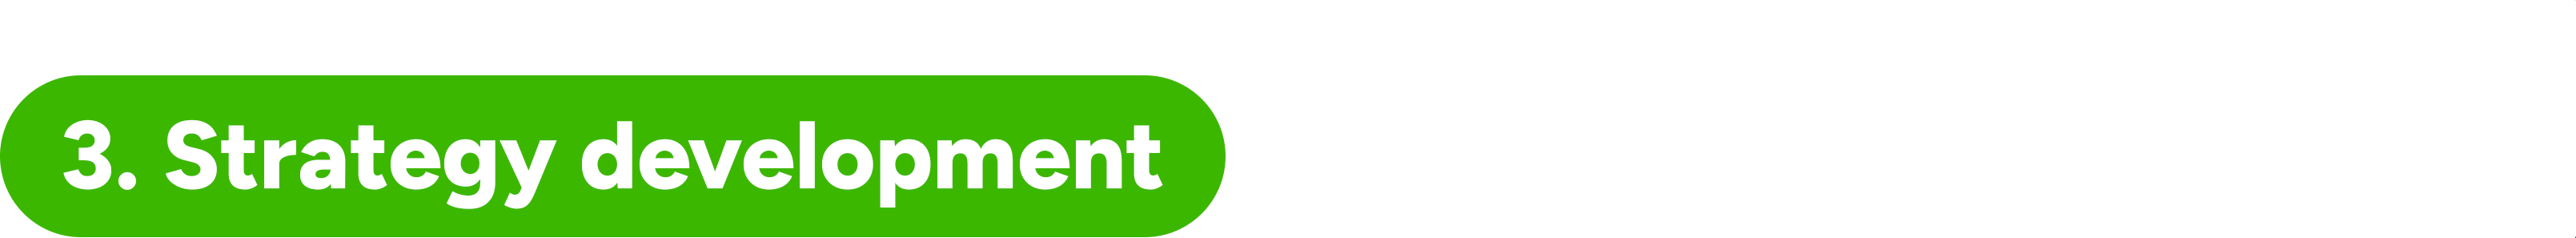

Simplest strat: classic moving average crossover type.

At every bar calculate the 10-day and 30-day simple moving averages (SMA)

If the 10-day SMA exceeds the 30-day SMA and the strategy is not invested, then go long

If the 30-day SMA exceeds the 10-day SMA and the strategy is invested, then close the position

https://arxiv.org/pdf/2009.10065

file:///C:/Users/kalul/Downloads/Dataselectionpairsavoidoverfitting.pdf


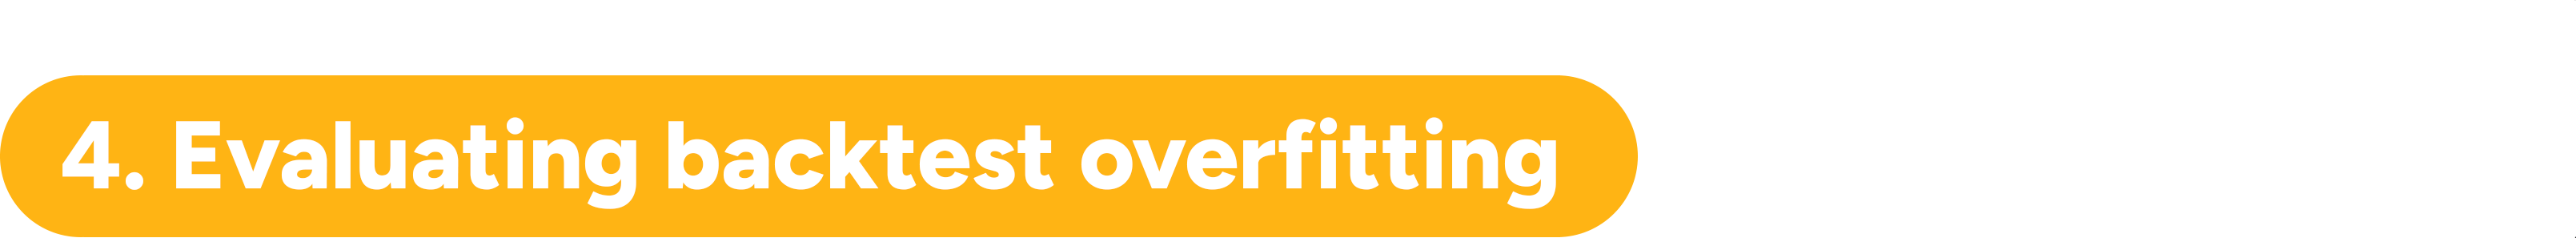